In [745]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style = "whitegrid")

In [746]:
# Definir funciones

def is_outlier_iqr(lista, threshold=1.5):
    '''
    Input: serie
    Return: boolean mask definiendo si es un outlier (true) usando IQR
    '''
    q75, q25 = np.percentile(lista, [75 ,25])
    iqr = q75 - q25
    mn = q25 - (iqr*threshold)
    mx = q75 + (iqr*threshold)
    return (lista <= mn) | (lista >= mx) 


def is_outlier_mad(lista, threshold=3.5):
    '''
    Input: serie
    Return: boolean mask definiendo si es un outlier (true) usando Modified MAD
    '''
    if len(lista.shape) == 1:
        lista = lista[:,None]
    median = np.median(lista, axis=0)
    diff = np.sum((lista - median)**2, axis=-1)
    diff = np.sqrt(diff)
    mad = np.median(diff)
    modified_z_score = 0.6745 * diff / mad
    return modified_z_score >= threshold
    
def plot_filtro(lista, bool_filter=is_outlier_mad):
    '''
    Input: serie y formula para eliminar outliers
    Return: subplots con la distribucion original (boxplot) y la filtrada de outliers (hist & kde)
    '''
    lista_filtrada = lista[~bool_filter(lista)]

    plt.figure(figsize=(12,8))
    
    plt.subplot(211)
    sns.boxplot(lista)
    plt.title('Lista Original')
    

    plt.subplot(212)
    sns.distplot(lista_filtrada)
    plt.title('Lista Filtrada')
    
    plt.tight_layout()
    plt.show()
    
def plot_dist(lista):
    '''
    Input: serie
    Return: subplots con la distribucion original boxplot e hist&kde
    '''
    plt.figure(figsize=(12,8))
    
    plt.subplot(211)
    sns.boxplot(lista)
    plt.title(f'{lista.name}\n Max={np.max(lista):.0f} Median={np.median(lista):.0f} Min={np.min(lista):.0f}')

    plt.subplot(212)
    sns.distplot(lista)

    plt.tight_layout()
    plt.show()

In [747]:
# Read data
# Lectura del dataset usando como index la primera columna
df = pd.read_csv('properatti.csv', index_col=0)

In [748]:
# Revisar info general del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121220 entries, 0 to 121219
Data columns (total 25 columns):
operation                     121220 non-null object
property_type                 121220 non-null object
place_name                    121197 non-null object
place_with_parent_names       121220 non-null object
country_name                  121220 non-null object
state_name                    121220 non-null object
geonames_id                   102503 non-null float64
lat-lon                       69670 non-null object
lat                           69670 non-null float64
lon                           69670 non-null float64
price                         100810 non-null float64
currency                      100809 non-null object
price_aprox_local_currency    100810 non-null float64
price_aprox_usd               100810 non-null float64
surface_total_in_m2           81892 non-null float64
surface_covered_in_m2         101313 non-null float64
price_usd_per_m2              68617 n

In [749]:
# Revisar contenido de columnas
for col in df.columns:
    print(f'col: {col} --> contenido: {df[col].unique()}')

col: operation --> contenido: ['sell']
col: property_type --> contenido: ['PH' 'apartment' 'house' 'store']
col: place_name --> contenido: ['Mataderos' 'La Plata' 'Liniers' ... 'Laguna Paiva' 'Malabrigo'
 'Altos de Hudson I']
col: place_with_parent_names --> contenido: ['|Argentina|Capital Federal|Mataderos|'
 '|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|'
 '|Argentina|Capital Federal|Liniers|' ...
 '|Argentina|Santa Fe|Laguna Paiva|' '|Argentina|Santa Fe|Malabrigo|'
 '|Argentina|Bs.As. G.B.A. Zona Sur|Berazategui|Altos de Hudson I|']
col: country_name --> contenido: ['Argentina']
col: state_name --> contenido: ['Capital Federal' 'Bs.As. G.B.A. Zona Sur' 'Buenos Aires Costa Atlántica'
 'Entre Ríos' 'Bs.As. G.B.A. Zona Norte' 'Santa Fe' 'Córdoba'
 'Bs.As. G.B.A. Zona Oeste' 'Misiones' 'Buenos Aires Interior' 'Salta'
 'Neuquén' 'Río Negro' 'San Luis' 'Mendoza' 'Corrientes' 'Chubut'
 'Tucumán' 'La Pampa' 'Chaco' 'San Juan' 'Santa Cruz' 'Tierra Del Fuego'
 'Catamarca' 'Santiago Del Estero' 

col: properati_url --> contenido: ['http://www.properati.com.ar/15bo8_venta_ph_mataderos_lavadero_patio_inmobiliaria-fedele'
 'http://www.properati.com.ar/15bob_venta_departamentos_la-plata_balcon_lavadero_toilette_garage_estrenar_antonini-propiedades_dcp'
 'http://www.properati.com.ar/15bod_venta_departamentos_mataderos_lavadero_placard_inmobiliaria-fedele'
 ...
 'http://www.properati.com.ar/1cja7_venta_departamento_villa-urquiza_holmberg_2300_balcon_lavadero_parrilla_terraza_electrogeno_garage_amenities_placard_aire-acondicionado_estrenar_triada-propiedades_geg'
 'http://www.properati.com.ar/1cja8_venta_departamento_plaza-colon_lavadero_luminoso_dependencias_impecable_placard_girard-propiedades_gkl'
 'http://www.properati.com.ar/1cjaa_venta_departamento_capital-federal_baulera_lavadero_lujoso_dependencias_izrastzoff-compania-inmobiliaria']
col: description --> contenido: ['2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO, REFACCIONADO A NUEVO, PATIO GRANDE, CON LAVADERO, LIVING COMEDOR 

**Conclusiones:**  
    - operation: Hay solo registros con operaciones de venta ('sell'). ELIMINAR.
    - place_name: barrios. OK. ver duplicados.
    - property_type: Filtrar por 'apartment'  
    - place_with_parent_names: Info duplicada. ELIMINAR.  
    - country_name: hay solo registros en Argentina. ELIMINAR..  
    - state_name: CABA y provincias. Filtrar por CABA.
    - geonames_id: Por si es utilizable con otra herramienta. ELIMINAR.
    - lat-lon: Info duplicada. Mismos nulls que en otras celdas. ELIMINAR.  
    - lat: OK.   
    - lon: OK. 
    - price, currency, price_aprox_local_currency: ELIMINAR.  
    - price_aprox_usd: OK.  
    - surface_total_in_m2, surface_covered_in_m2: OK.  
    - price_usd_per_m2: calculable. revisar por diferente cantidad de nulls. REVISAR.
    - price_per_m2: REVISAR.
    - floor: Piso de departamentos y de PH. Muchos outliers. REVISAR.
    - rooms: OK.  
    - expenses: OK.  
    - properati_url: ELIMINAR.
    - description: OK.  
    - title: ELIMINAR. 
    - image_thumbnail: ELIMINAR.  

In [750]:
# Seleccionar columnas utilizables y filtrar por filas seleccionadas
selected_columns = [ 'place_name','lat', 'lon', 'surface_total_in_m2', 'surface_covered_in_m2', 'price',
                     'currency', 'price_aprox_local_currency', 'price_aprox_usd', 'price_usd_per_m2', 
                     'price_per_m2', 'floor', 'rooms', 'expenses', 'description']
df = df.loc[((df['state_name'] == 'Capital Federal') & (df['property_type'] == 'apartment')), selected_columns]

In [751]:
# Filtrar lat & lon por notnull() -- Para trabajar luego con geopandas
df = df.loc[ ((df['lat'].notnull()) & (df['lon'].notnull())), ]

In [752]:
# Seleccionar rows con 'Palermo' en el 'place_name' y reemplazar 'place_name' == 'Palermo'. 
# Deja 58 barrios en place_name. Para utilizar info geografica por barrios del Buenos Aires Data.
df.loc[df['place_name'].str.contains('Palermo'), ['place_name'] ] = 'Palermo'

### Revisar columnas de precios

In [753]:
selected_columns = ['price', 'currency', 'price_aprox_local_currency', 'price_aprox_usd', 'price_usd_per_m2', 'price_per_m2']
df.loc[df.price.isnull(), selected_columns].shape
df.loc[df.price.isnull(), selected_columns].head()

(1247, 6)

,price,currency,price_aprox_local_currency,price_aprox_usd,price_usd_per_m2,price_per_m2
214,NaN,NaN,NaN,NaN,NaN,NaN
217,NaN,NaN,NaN,NaN,NaN,NaN
223,NaN,NaN,NaN,NaN,NaN,NaN
545,NaN,NaN,NaN,NaN,NaN,NaN
546,NaN,NaN,NaN,NaN,NaN,NaN


De los **19446** datos de apartamentos en CABA con `lat` y `lon`, **1247**
 datos tienen *nan* en `price` y si tienen *nan* en `price` tienen *nan* en todas las columnas.  


In [754]:
# Eliminar rows con 'nan' en 'price'
df = df.loc[df['price'].notnull(), ]
df.shape # deberia restar los 1247 de los 19446 = 18199 -- correcto.

(18199, 15)

In [755]:
df.loc[df.currency != 'USD', selected_columns].head()
df.loc[df.currency != 'USD', selected_columns].shape

,price,currency,price_aprox_local_currency,price_aprox_usd,price_usd_per_m2,price_per_m2
97,1423800.0,ARS,1408947.37,79851.93,NaN,NaN
351,1099350.0,ARS,1087882.05,61655.59,2283.540370,40716.666667
352,1113420.0,ARS,1101805.15,62444.68,2312.765926,41237.777778
353,1127700.0,ARS,1115936.28,63245.56,2342.428148,41766.666667
354,1141980.0,ARS,1130067.23,64046.43,2372.090000,42295.555556


(650, 6)

Existen valores en la columna `price_m2` en pesos que se pueden transformar en usd para las filas donde `price_usd_per_m2` es *nan* usando el tipo de cambio implicito entre las columnas `price_aprox_local_currency` y `price_aprox_usd`.  
Hay una diferencia constante `price_aprox_local_currency` < `price` para la muestra. *REVISAR para modelo predictivo*

In [756]:
# crear una columna con tipo de cambio implicito.
df['fx'] = df['price_aprox_local_currency'] / df['price_aprox_usd']
df['fx'].unique().mean() # siempre el mismo utilizado para toda la base

17.644499950442807

In [757]:
# para las filas con 'currency' == 'ARS', 'price_usd_per_m2' = null y 'price_per_m2' = notnull completar usando
# 'price_per_m2' / 'fx'
mask = (df['currency'] == 'ARS') & (df['price_usd_per_m2'].isnull()) & (df['price_per_m2'].notnull())
df.loc[ mask , ['price_usd_per_m2'] ] = df['price_per_m2'] / df['fx']

In [758]:
# revisar las filas con 'price_usd_per_m2' isnull
df.loc[df.price_usd_per_m2.isnull(), selected_columns].head()
df.loc[df.price_usd_per_m2.isnull(), selected_columns].shape

,price,currency,price_aprox_local_currency,price_aprox_usd,price_usd_per_m2,price_per_m2
97,1423800.0,ARS,1408947.37,79851.93,NaN,NaN
120,178000.0,USD,3140721.00,178000.00,NaN,3236.363636
157,129000.0,USD,2276140.50,129000.00,NaN,1612.500000
166,128000.0,USD,2258496.00,128000.00,NaN,2509.803922
167,118000.0,USD,2082051.00,118000.00,NaN,1661.971831


(3638, 6)

Existen `price_per_m2` notnull para `currency` == 'USD'. Completar *nan* de `price_usd_per_m2` con `price_m2`

In [759]:
# Completar 'nan' de 'price_usd_per_m2' con 'price_m2' cuando sea posible
mask = (df['currency'] == 'USD') & (df['price_usd_per_m2'].isnull()) & (df['price_per_m2'].notnull())
df.loc[ mask , ['price_usd_per_m2'] ] = df['price_per_m2']

### Revisar columnas de superficies

In [760]:
selected_columns = ['surface_total_in_m2', 'surface_covered_in_m2','price_aprox_usd', 'price_usd_per_m2']

In [761]:
# Ver si se pueden recuperar superficies implicitas de los precios totales y por m2
mask = (df['surface_total_in_m2'].isnull()) & (df['surface_covered_in_m2'].isnull()) & (df['price_per_m2'].notnull())
df.loc[ mask, selected_columns].shape

(0, 4)

No existen estos casos.

In [762]:
# Ver rows sup total notnull y sup cub notnull  
mask = (df['surface_total_in_m2'].notnull()) & (df['surface_covered_in_m2'].notnull())
df.loc[ mask, selected_columns].head()
df.loc[ mask, selected_columns].shape

,surface_total_in_m2,surface_covered_in_m2,price_aprox_usd,price_usd_per_m2
2,55.0,55.0,72000.0,1309.090909
7,45.0,40.0,138000.0,3066.666667
8,65.0,60.0,195000.0,3000.000000
19,104.0,96.0,350000.0,3365.384615
21,118.0,73.0,270500.0,2292.372881


(13920, 4)

Hay **13920** datos y el dato por m2 parece calculado sobre la sup total

In [763]:
# Ver rows con sup total null y sup cub not null  
mask = (df['surface_total_in_m2'].isnull()) & (df['surface_covered_in_m2'].notnull())
df.loc[ mask, selected_columns].head()
df.loc[ mask, selected_columns].shape

,surface_total_in_m2,surface_covered_in_m2,price_aprox_usd,price_usd_per_m2
120,NaN,55.0,178000.0,3236.363636
157,NaN,80.0,129000.0,1612.500000
166,NaN,51.0,128000.0,2509.803922
167,NaN,71.0,118000.0,1661.971831
178,NaN,35.0,93000.0,2657.142857


(3460, 4)

Hay **3460** datos y el dato por m2 parece calculado sobre la sup cubierta

In [764]:
# Ver rows sup total notnull y sup cub null
mask = (df['surface_total_in_m2'].notnull()) & (df['surface_covered_in_m2'].isnull())
df.loc[ mask, selected_columns].head()
df.loc[ mask, selected_columns].shape

,surface_total_in_m2,surface_covered_in_m2,price_aprox_usd,price_usd_per_m2
66,38.0,NaN,72900.0,1918.421053
914,69.0,NaN,170000.0,2463.768116
5404,90.0,NaN,285000.0,3166.666667
5431,36.0,NaN,110000.0,3055.555556
5716,43.0,NaN,140000.0,3255.813953


(508, 4)

Hay **508** datos y el dato por m2 parece calculado sobre la sup total

In [765]:
# Reemplazar los 'nan' en 'sup total' por 'sup cub' cuando esta es notnull
mask = (df['surface_total_in_m2'].isnull()) & (df['surface_covered_in_m2'].notnull())
df.loc[ mask , ['surface_total_in_m2'] ] = df['surface_covered_in_m2']

In [766]:
# Revisar los casos residuales donde 'sup total' isnull
mask = df['surface_total_in_m2'].isnull()
df.loc[ mask, selected_columns].head()
df.loc[mask, 'surface_covered_in_m2'].isnull().all()
df.loc[mask, 'price_usd_per_m2'].isnull().all()

,surface_total_in_m2,surface_covered_in_m2,price_aprox_usd,price_usd_per_m2
97,NaN,NaN,79851.93,NaN
429,NaN,NaN,130000.00,NaN
1396,NaN,NaN,81200.00,NaN
1400,NaN,NaN,79000.00,NaN
1402,NaN,NaN,150000.00,NaN


True

True

Existen 311 casos sin datos de superficie ni de precio por m2 para inferir.

In [767]:
# Eliminar las rows remanentes donde sup total isnull
df.dropna(subset=['surface_total_in_m2'], axis=0, inplace=True)

In [768]:
# Revisar los casos donde sup cubierta es mayor a superficie total y reemplazar valor
mask = (df['surface_total_in_m2'] < df['surface_covered_in_m2'])
df.loc[ mask , ['surface_total_in_m2'] ] = df['surface_covered_in_m2']

In [769]:
mask = df['price_usd_per_m2'].isnull()
df.loc[ mask, selected_columns]

,surface_total_in_m2,surface_covered_in_m2,price_aprox_usd,price_usd_per_m2
18156,0.0,NaN,780000.0,NaN
32474,0.0,NaN,320000.0,NaN
36809,0.0,NaN,68500.0,NaN
41491,0.0,NaN,175000.0,NaN
45900,0.0,NaN,135000.0,NaN
110938,0.0,NaN,112000.0,NaN


In [770]:
# Eliminar los 6 casos
df.dropna(subset=['price_usd_per_m2'], axis=0, inplace=True)

In [771]:
# Revisar si quedan casos de sup total == 0 (que es notnull)
mask = df['surface_total_in_m2'] == 0
df.loc[ mask, selected_columns].shape

(0, 4)

No queda ninguna row con sup total == 0

### Eliminar columnas no utilizadas y cambiar el nombre

In [772]:
# Eliminar columnas
df.drop(axis=1, columns=['price','currency','price_aprox_local_currency','price_aprox_usd','price_per_m2','fx'],
        inplace=True)

In [773]:
# Simplificar nombre de columnas.
df.columns = ['barrio','lat','lon','total','cubierta','precio','piso','habs','expensas','descripcion']

### Revisar y eliminar duplicados

In [774]:
# Buscar duplicados
df.duplicated().sum()

435

In [775]:
df[df.duplicated()].head(10)

,barrio,lat,lon,total,cubierta,precio,piso,habs,expensas,descripcion
221,Belgrano,-34.565265,-58.438233,69.0,53.0,3447.753623,NaN,2.0,NaN,El edificio está situado en el barrio de las ...
400,Puerto Madero,-34.617915,-58.361766,54.0,50.0,6481.481481,NaN,2.0,NaN,"En su dique 1, y delimitado por el Boulevard J..."
4708,Caballito,-34.628180,-58.429483,37.0,37.0,3445.945946,NaN,1.0,NaN,"Venta - Departamento - Argentina, Buenos Aires..."
4710,Caballito,-34.628180,-58.429483,36.0,36.0,3555.555556,NaN,1.0,NaN,"Venta - Departamento - Argentina, Buenos Aires..."
4713,Caballito,-34.628180,-58.429483,36.0,36.0,3430.555556,NaN,1.0,NaN,"Venta - Departamento - Argentina, Buenos Aires..."
4715,Caballito,-34.628180,-58.429483,36.0,36.0,3458.333333,NaN,1.0,NaN,"Venta - Departamento - Argentina, Buenos Aires..."
4879,Barracas,-34.631882,-58.376250,93.0,77.0,1827.956989,NaN,3.0,NaN,"Espaciosa y amplia Unidad, construida con mate..."
6249,Coghlan,-34.563374,-58.482839,55.0,50.0,2254.545455,3.0,NaN,NaN,"Edificio A ESTRENAR, muy buena calidad de cons..."
6254,Coghlan,-34.563374,-58.482839,55.0,50.0,2254.545455,3.0,NaN,NaN,"Edificio A ESTRENAR, muy buena calidad de cons..."
6259,Coghlan,-34.563374,-58.482839,35.0,30.0,2685.714286,2.0,NaN,NaN,"Edificio A ESTRENAR, muy buena calidad de cons..."


In [776]:
# Eliminar duplicados
df.drop_duplicates(inplace=True)

### Detectar y eliminar outliers

In [777]:
df.describe()

,lat,lon,total,cubierta,precio,piso,habs,expensas
count,17447.000000,17447.000000,17447.000000,16956.000000,1.744700e+04,2603.000000,11258.000000,4.299000e+03
mean,-34.598615,-58.432535,105.770562,87.138535,2.992093e+03,13.541683,2.648161,7.967335e+03
std,0.038309,0.054775,2077.164674,1442.958290,1.990899e+04,87.588963,1.452740,2.156624e+05
min,-38.416097,-63.616672,1.000000,0.000000,3.208556e+00,1.000000,1.000000,1.000000e+00
25%,-34.617960,-58.460526,42.000000,38.000000,2.056719e+03,2.000000,2.000000,1.300000e+03
50%,-34.598935,-58.433102,59.000000,53.000000,2.469444e+03,4.000000,2.000000,2.100000e+03
75%,-34.579544,-58.401509,93.000000,84.000000,3.010782e+03,7.000000,4.000000,3.800000e+03
max,-34.534530,-58.354956,200000.000000,187000.000000,2.600000e+06,2509.000000,22.000000,1.000150e+07


In [778]:
# Eliminar precios económicamente irracionales
df = df.loc[(df.precio > 500) & (df.precio<10000), ]
# Eliminar superficies ilógicas
df = df.loc[(df.total > 10) & (df.total<1000), ]

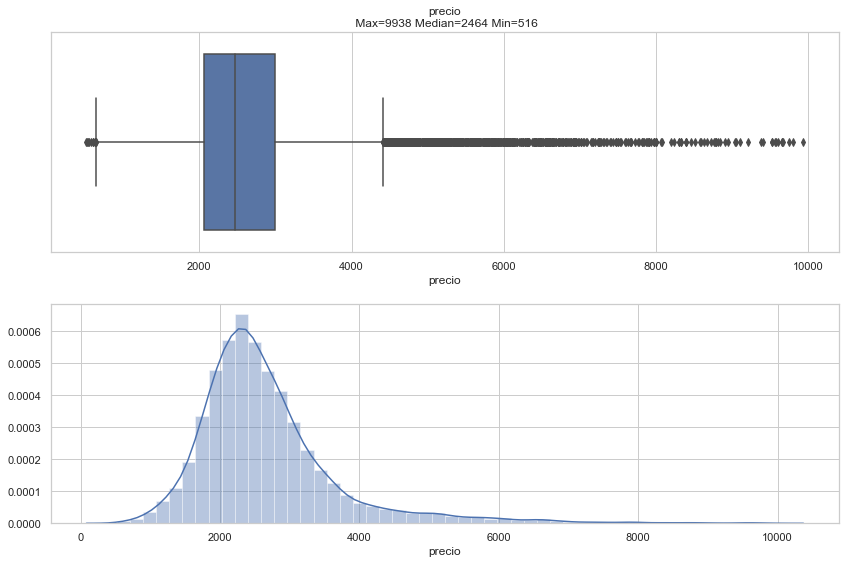

In [779]:
plot_dist(df.precio)

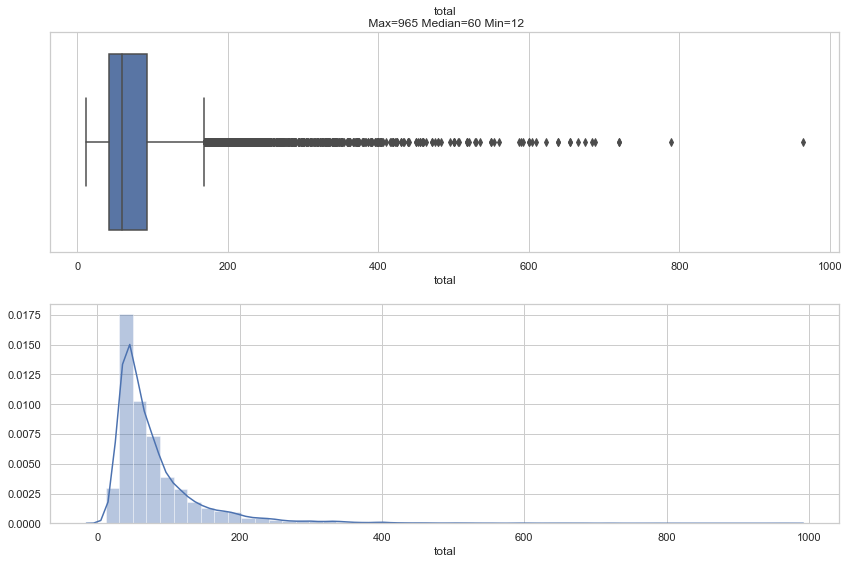

In [780]:
plot_dist(df.total)

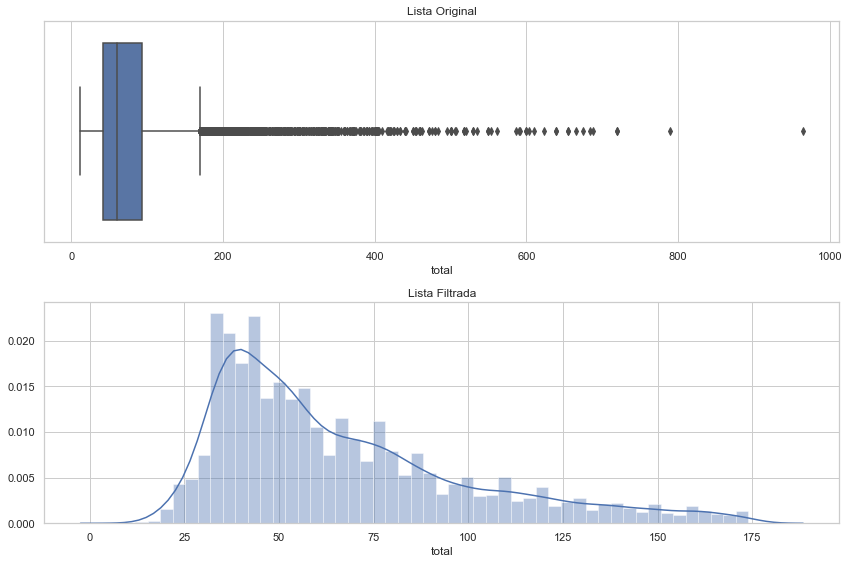

In [781]:
plot_filtro(df.total)

In [782]:
# Eliminar las superficies consideradas fuera del estándar o outliers para el análisis de departamentos promedio.
df = df.loc[~is_outlier_mad(df.total), :]

### Dataset Clean

In [783]:
df.describe()

,lat,lon,total,cubierta,precio,piso,habs,expensas
count,15948.000000,15948.000000,15948.000000,15491.000000,15948.000000,2465.000000,10109.000000,3.956000e+03
mean,-34.599041,-58.434260,66.264234,60.380866,2606.674657,13.806085,2.429914,7.700578e+03
std,0.039410,0.055931,33.410658,30.998327,893.115524,89.433388,1.169017,2.248053e+05
min,-38.416097,-63.616672,12.000000,0.000000,535.344091,1.000000,1.000000,1.000000e+00
25%,-34.618423,-58.462086,41.000000,37.000000,2057.142857,2.000000,1.000000,1.250000e+03
50%,-34.599767,-58.435231,56.000000,50.000000,2444.444444,4.000000,2.000000,2.000000e+03
75%,-34.579787,-58.403764,83.000000,75.000000,2943.426799,7.000000,3.000000,3.300000e+03
max,-34.534530,-58.354956,174.000000,174.000000,9937.888199,2509.000000,10.000000,1.000150e+07


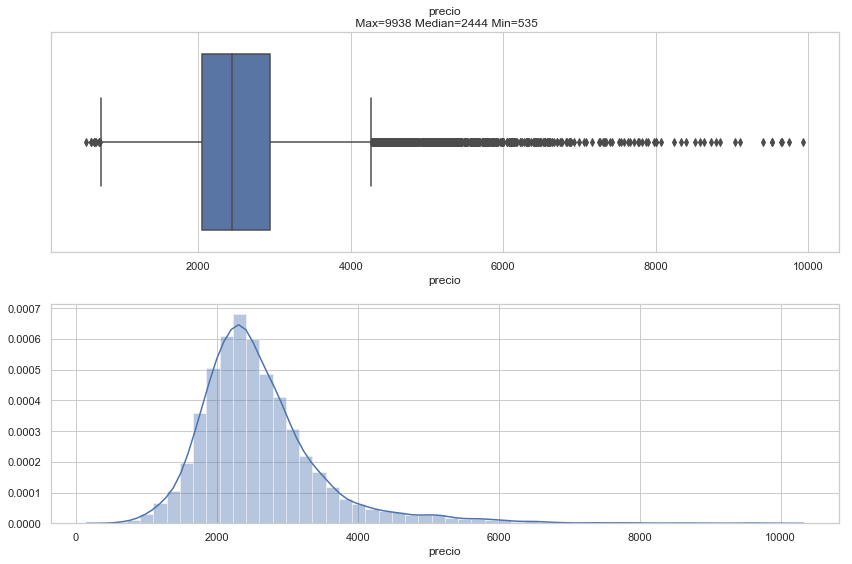

In [784]:
plot_dist(df.precio)

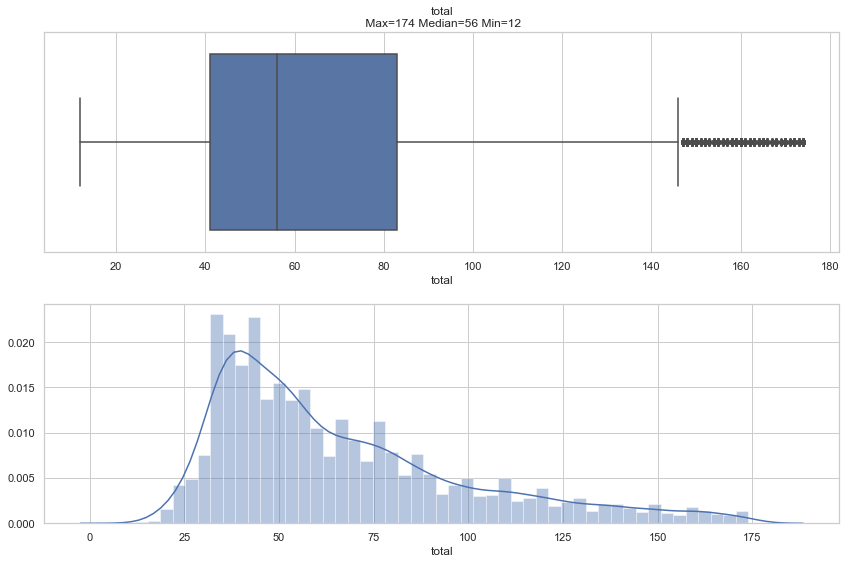

In [785]:
plot_dist(df.total)

### Regex Descripciones

#### Cantidad de Ambientes

Diccionario para mapear los textos a numeros

In [786]:
numeros_en_letras = {'uno' : '1' , 'dos' : '2' , 'tres' : '3' , 'cuatro' : '4' ,
                     'cinco' : '5' , 'seis' : '6' , 'siete' : '7' , 'mono' : '1' ,
                     'mon' : '1' , 'nan' : np.nan}

Aca seteamos la REGEX para extraer la cantidad de ambientes

In [787]:
pattern = r'(uno\s|dos\s|tres\s|cuatro\s|cinco\s|seis\s|siete\s|\d+?\s|mono?)amb{0,1}'
df['ambientes'] = ""
df['ambientes'] = df['descripcion'].str.extract(pattern , flags=re.IGNORECASE , expand=True)

In [788]:
check = df
print("Cantidad de Observaciones nuevas --> " , check[(check['habs'].isnull()) & (check['ambientes'].notnull())].count()['ambientes'])

Cantidad de Observaciones nuevas -->  4386


In [789]:
df['ambientes'] = df['ambientes'].str.lower()
df['ambientes'].unique()

array(['2 ', 'mono', 'dos ', nan, 'cuatro ', '3 ', '4 ', '1 ', '5 ', '6 ',
       'tres ', '042 ', 'dos\xa0', '42026 ', 'cuatro\xa0', '902 ', '18 ',
       '000 ', 'cinco ', '944 ', 'tres\xa0', '7 ', '8 ', '12 ', '43 ',
       '22 ', '42022 ', '281 ', '24 ', '20173 ', '1200 ', '772 ', '653 ',
       '983 ', '42025 ', '42004 ', '42046 ', '502 ', '42049 ', '152 ',
       '412 ', '42015 ', '42021 ', '172 ', 'mon', '693 ', '622 ', '183 ',
       '793 ', '262 ', '253 ', '913 ', '20171 ', '20172 ', '853 ', '202 ',
       '192 ', '113 ', '2004 ', '822 ', '562 ', '23 ', '164 ', '733 ',
       '312 '], dtype=object)

In [790]:
df['ambientes'] = df['ambientes'].astype('str')
df['ambientes'].dtypes

dtype('O')

In [791]:
df['ambientes'] = df['ambientes'].str.strip()
df['ambientes'].unique()

array(['2', 'mono', 'dos', 'nan', 'cuatro', '3', '4', '1', '5', '6',
       'tres', '042', '42026', '902', '18', '000', 'cinco', '944', '7',
       '8', '12', '43', '22', '42022', '281', '24', '20173', '1200',
       '772', '653', '983', '42025', '42004', '42046', '502', '42049',
       '152', '412', '42015', '42021', '172', 'mon', '693', '622', '183',
       '793', '262', '253', '913', '20171', '20172', '853', '202', '192',
       '113', '2004', '822', '562', '23', '164', '733', '312'],
      dtype=object)

Reemplazamos los numeros en 'letras' a numeros en digitos

In [792]:
df['ambientes'].replace(numeros_en_letras , inplace=True)
df['ambientes'].unique()

array(['2', '1', nan, '4', '3', '5', '6', '042', '42026', '902', '18',
       '000', '944', '7', '8', '12', '43', '22', '42022', '281', '24',
       '20173', '1200', '772', '653', '983', '42025', '42004', '42046',
       '502', '42049', '152', '412', '42015', '42021', '172', '693',
       '622', '183', '793', '262', '253', '913', '20171', '20172', '853',
       '202', '192', '113', '2004', '822', '562', '23', '164', '733',
       '312'], dtype=object)

In [793]:
df.head(10)

,barrio,lat,lon,total,cubierta,precio,piso,habs,expensas,descripcion,ambientes
2,Mataderos,-34.652262,-58.522982,55.0,55.0,1309.090909,NaN,NaN,NaN,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2
7,Belgrano,-34.559873,-58.443362,45.0,40.0,3066.666667,NaN,NaN,NaN,EXCELENTE MONOAMBIENTE A ESTRENAR AMPLIO SUPER...,1
8,Belgrano,-34.559873,-58.443362,65.0,60.0,3000.000000,NaN,NaN,NaN,EXCELENTE DOS AMBIENTES ESTRENAR AMPLIO SUPER...,2
19,Palermo,-34.580504,-58.405874,104.0,96.0,3365.384615,NaN,3.0,NaN,Excelente semipiso al contra frente en Bulnes ...,NaN
21,Palermo,-34.590926,-58.411665,118.0,73.0,2292.372881,NaN,4.0,NaN,"EXCELENTE ZONA, MULTIPLES MEDIOS DE TRANSPORTE...",NaN
29,Flores,-34.635118,-58.473964,43.0,43.0,1744.186047,NaN,2.0,NaN,Departamento muy luminoso con todos sus ambien...,NaN
35,Boedo,-34.621769,-58.422108,80.0,77.0,1812.500000,NaN,4.0,NaN,"Hermoso departamento de cuatro ambientes, refa...",4
48,Balvanera,-34.609675,-58.398659,141.0,124.0,1702.127660,NaN,5.0,NaN,"PISO 13, Orientación norte, disposición al fre...",NaN
52,Caballito,-34.622211,-58.439128,50.0,50.0,2200.000000,NaN,3.0,NaN,Departamento de 3 Ambientes al Contrafrente. S...,3
53,Caballito,-34.623894,-58.446861,100.0,46.0,1705.000000,NaN,2.0,NaN,14 exclusivos semi-pisos.Excelentes detalles d...,NaN


In [794]:
df['habitaciones_final'] = df['habs']
df['habitaciones_final'] = df['habitaciones_final'].fillna(df['ambientes'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15948 entries, 2 to 121217
Data columns (total 12 columns):
barrio                15948 non-null object
lat                   15948 non-null float64
lon                   15948 non-null float64
total                 15948 non-null float64
cubierta              15491 non-null float64
precio                15948 non-null float64
piso                  2465 non-null float64
habs                  10109 non-null float64
expensas              3956 non-null float64
descripcion           15948 non-null object
ambientes             11649 non-null object
habitaciones_final    14495 non-null object
dtypes: float64(8), object(4)
memory usage: 1.6+ MB


In [795]:
df['habitaciones_final'] = df['habitaciones_final'].dropna().astype('int64')

In [796]:
df.head()

,barrio,lat,lon,total,cubierta,precio,piso,habs,expensas,descripcion,ambientes,habitaciones_final
2,Mataderos,-34.652262,-58.522982,55.0,55.0,1309.090909,NaN,NaN,NaN,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2,2.0
7,Belgrano,-34.559873,-58.443362,45.0,40.0,3066.666667,NaN,NaN,NaN,EXCELENTE MONOAMBIENTE A ESTRENAR AMPLIO SUPER...,1,1.0
8,Belgrano,-34.559873,-58.443362,65.0,60.0,3000.000000,NaN,NaN,NaN,EXCELENTE DOS AMBIENTES ESTRENAR AMPLIO SUPER...,2,2.0
19,Palermo,-34.580504,-58.405874,104.0,96.0,3365.384615,NaN,3.0,NaN,Excelente semipiso al contra frente en Bulnes ...,NaN,3.0
21,Palermo,-34.590926,-58.411665,118.0,73.0,2292.372881,NaN,4.0,NaN,"EXCELENTE ZONA, MULTIPLES MEDIOS DE TRANSPORTE...",NaN,4.0


#### Amenities

In [797]:
amenities = ['pileta', 'seguridad', 'parrilla', 'balcon', 'cochera', 'nuevo']

In [798]:
# funcion que recibe un objeto string, y matchea palabras vs regex en un dict predefinido

def split_clean_build(x, keys):
    
    # inicializo el dataframe que va a tener los datos de las cols
    d = {col: 0 for col in keys}
    
    frase = x.lower()
    
    # matches
    if re.search(r'pile|pisc', frase): 
        d[keys[0]] = 1
    if re.search(r'segur|vigil', frase): 
        d[keys[1]] = 1
    if re.search(r'parri', frase): 
        d[keys[2]] = 1
    if re.search(r'balcon|balcón', frase): 
        d[keys[3]] = 1
    if re.search(r'coch', frase): 
        d[keys[4]] = 1
    if re.search(r'pozo|nuev', frase): 
        d[keys[5]] = 1
    
    return pd.DataFrame.from_dict(d, orient='index').T

In [799]:
dummy = pd.DataFrame(columns=amenities)

for row in df.descripcion:
    line = split_clean_build(row, amenities)
    dummy = pd.concat([dummy, line])

In [800]:
df.reset_index(inplace=True)
dummy.reset_index(inplace=True)
dummy.drop('index', axis=1, inplace=True)

In [801]:
df = df.join(dummy)

In [802]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15948 entries, 0 to 15947
Data columns (total 19 columns):
index                 15948 non-null int64
barrio                15948 non-null object
lat                   15948 non-null float64
lon                   15948 non-null float64
total                 15948 non-null float64
cubierta              15491 non-null float64
precio                15948 non-null float64
piso                  2465 non-null float64
habs                  10109 non-null float64
expensas              3956 non-null float64
descripcion           15948 non-null object
ambientes             11649 non-null object
habitaciones_final    14495 non-null float64
pileta                15948 non-null object
seguridad             15948 non-null object
parrilla              15948 non-null object
balcon                15948 non-null object
cochera               15948 non-null object
nuevo                 15948 non-null object
dtypes: float64(9), int64(1), object(9)
memory us

In [803]:
df.shape
df.rename({'index': 'id'}, axis=1,  inplace=True)
df.head(20)

(15948, 19)

,id,barrio,lat,lon,total,cubierta,precio,piso,habs,expensas,descripcion,ambientes,habitaciones_final,pileta,seguridad,parrilla,balcon,cochera,nuevo
0,2,Mataderos,-34.652262,-58.522982,55.0,55.0,1309.090909,NaN,NaN,NaN,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2,2.0,0,0,0,0,0,0
1,7,Belgrano,-34.559873,-58.443362,45.0,40.0,3066.666667,NaN,NaN,NaN,EXCELENTE MONOAMBIENTE A ESTRENAR AMPLIO SUPER...,1,1.0,1,0,0,0,0,0
2,8,Belgrano,-34.559873,-58.443362,65.0,60.0,3000.000000,NaN,NaN,NaN,EXCELENTE DOS AMBIENTES ESTRENAR AMPLIO SUPER...,2,2.0,1,0,0,0,0,0
3,19,Palermo,-34.580504,-58.405874,104.0,96.0,3365.384615,NaN,3.0,NaN,Excelente semipiso al contra frente en Bulnes ...,NaN,3.0,0,0,0,1,0,0
4,21,Palermo,-34.590926,-58.411665,118.0,73.0,2292.372881,NaN,4.0,NaN,"EXCELENTE ZONA, MULTIPLES MEDIOS DE TRANSPORTE...",NaN,4.0,0,0,0,0,0,0
5,29,Flores,-34.635118,-58.473964,43.0,43.0,1744.186047,NaN,2.0,NaN,Departamento muy luminoso con todos sus ambien...,NaN,2.0,0,0,0,1,0,0
6,35,Boedo,-34.621769,-58.422108,80.0,77.0,1812.500000,NaN,4.0,NaN,"Hermoso departamento de cuatro ambientes, refa...",4,4.0,0,0,0,1,0,1
7,48,Balvanera,-34.609675,-58.398659,141.0,124.0,1702.127660,NaN,5.0,NaN,"PISO 13, Orientación norte, disposición al fre...",NaN,5.0,0,0,0,1,1,0
8,52,Caballito,-34.622211,-58.439128,50.0,50.0,2200.000000,NaN,3.0,NaN,Departamento de 3 Ambientes al Contrafrente. S...,3,3.0,0,0,0,1,0,0
9,53,Caballito,-34.623894,-58.446861,100.0,46.0,1705.000000,NaN,2.0,NaN,14 exclusivos semi-pisos.Excelentes detalles d...,NaN,2.0,0,0,0,0,0,0


### Guardar el dataset clean & complete

In [804]:
df.to_csv('properatti_clean&complete.csv')